# Model Training

In [1]:
# data manipulation libraries
import pandas as pd
import numpy as np

# custom project libraries
from utils.wine_review_utils import load_augmented_data, RATINGS

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Load Augmented data

In [2]:
reviews = load_augmented_data()
reviews.info()
reviews.head()

<class 'pandas.core.frame.DataFrame'>
Index: 98460 entries, 0 to 129970
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   winery              98460 non-null  object 
 1   variety             98460 non-null  object 
 2   year                98460 non-null  int64  
 3   country             98460 non-null  object 
 4   price               91633 non-null  float64
 5   taster_name         98460 non-null  object 
 6   description         98460 non-null  object 
 7   points              98460 non-null  int64  
 8   rating              98460 non-null  object 
 9   description_length  98460 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 8.3+ MB


,winery,variety,year,country,price,taster_name,description,points,rating,description_length
0,Nicosia,White Blend,2013,Italy,NaN,Kerin O’Keefe,"Aromas include tropical fruit, broom, brimston...",87,very good,172
1,Quinta dos Avidagos,Portuguese Red,2011,Portugal,15.0,Roger Voss,"This is ripe and fruity, a wine that is smooth...",87,very good,227
2,Rainstorm,Pinot Gris,2013,US,14.0,Paul Gregutt,"Tart and snappy, the flavors of lime flesh and...",87,very good,186
3,St. Julian,Riesling,2013,US,13.0,Alexander Peartree,"Pineapple rind, lemon pith and orange blossom ...",87,very good,199
4,Sweet Cheeks,Pinot Noir,2012,US,65.0,Paul Gregutt,"Much like the regular bottling from 2012, this...",87,very good,249


## Training/Test Data Split

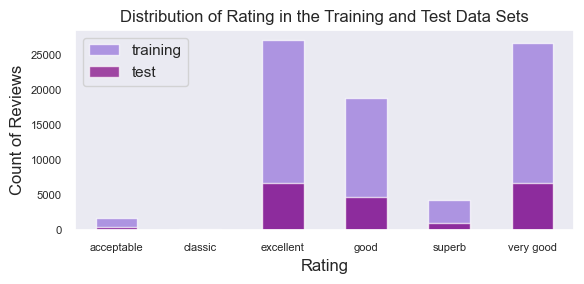

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# features
X = reviews[['variety', 'country', 'year', 'description_length', 'description']]
# target
le = LabelEncoder()
y = le.fit_transform(reviews.rating)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

# check the distribution of the target variable
fig = plt.figure(figsize=(6,3))
pd.Series(y_train).value_counts(normalize=False).sort_index().plot(kind='bar', color='mediumpurple', alpha=0.7, label='training')
pd.Series(y_test).value_counts(normalize=False).sort_index().plot(kind='bar', color='purple', alpha=0.7, label='test')
plt.title("Distribution of Rating in the Training and Test Data Sets")
plt.xlabel("Rating")
plt.ylabel("Count of Reviews")
plt.xticks(plt.xticks()[0], labels=le.inverse_transform(plt.xticks()[0]), fontsize=8, rotation=0)
plt.yticks(fontsize=8)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [4]:
# save the true y_test values
pd.Series(le.inverse_transform(y_test), name='y_test', index=X_test.index).to_frame().to_json('data/classifiers_y_test.json')

## Baseline Model

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import time

# define the baseline model
lr_pipe = Pipeline([
  ('preprocess', ColumnTransformer([('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['variety', 'country']),
                                    ('scaler', Pipeline([('poly', PolynomialFeatures(degree=2)), ('scaler', MinMaxScaler())]), ['year', 'description_length']),      
                                  ])
  ),
  ('lr', LogisticRegression(max_iter=500, C=.5, solver='saga')),
])

# fit the baseline model
start = time.perf_counter()
lr_pipe.fit(X_train.drop('description', axis=1), y_train)
duration = time.perf_counter()-start

# evaluate performance
accuracy_train = lr_pipe.score(X_train.drop('description', axis=1), y_train)
accuracy_test = lr_pipe.score(X_test.drop('description', axis=1), y_test)

print(f'Accuracy on training data: {accuracy_train:.1%}')
print(f'Accuracy on test data: {accuracy_test:.1%}')

Accuracy on training data: 52.7%
Accuracy on test data: 51.8%


In [6]:
from sklearn.metrics import confusion_matrix, classification_report

# the target classes
ratings = ['acceptable', 'good', 'very good', 'excellent', 'superb', 'classic']

# predictions on test data
y_preds = lr_pipe.predict(X_test)

# confusion matrix
conf_matrix = confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_preds), normalize='pred', labels=ratings)

# classification report
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_preds), labels=ratings, zero_division=0))

              precision    recall  f1-score   support

  acceptable       0.64      0.03      0.06       438
        good       0.53      0.53      0.53      4719
   very good       0.46      0.47      0.47      6669
   excellent       0.56      0.66      0.61      6778
      superb       0.49      0.06      0.11      1065
     classic       0.00      0.00      0.00        23

    accuracy                           0.52     19692
   macro avg       0.45      0.29      0.30     19692
weighted avg       0.52      0.52      0.50     19692



In [7]:
result_baseline = ('LogisticRegression', lr_pipe.named_steps['lr'], {'max_iter':500, 'C':0.5, 'solver':'saga'}, duration, accuracy_train, accuracy_test, conf_matrix)

## Feature Engineering

In [8]:
from sklearn.preprocessing import FunctionTransformer
from sentence_transformers import SentenceTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures

model = SentenceTransformer('all-mpnet-base-v2')
to_embeddings = lambda series: model.encode(series.to_list(), normalize_embeddings=False, show_progress_bar=True, device='mps')

to_features_out = lambda self, cols: [f'{i}' for i in range(768)]

transformer = ColumnTransformer([('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['variety', 'country']),
                                 ('scaler', Pipeline([('poly', PolynomialFeatures(degree=2)), ('scaler', MinMaxScaler())]), ['year', 'description_length']),
                                 ('embeds', Pipeline([('encode', FunctionTransformer(to_embeddings, feature_names_out=to_features_out)),
                                                      ('scaler', MinMaxScaler()),
                                                    ]), 'description'),
                                ])
transformer

ColumnTransformer(transformers=[('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='infrequent_if_exist'),
                                 ['variety', 'country']),
                                ('scaler',
                                 Pipeline(steps=[('poly', PolynomialFeatures()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['year', 'description_length']),
                                ('embeds',
                                 Pipeline(steps=[('encode',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x3e23aa480>,
                                                                      func=<function <lambda> at 0x3e23ab600>)),
                                                 ('scaler', MinMaxScaler())]),
                                 'description')])

## Preprocess the Data

Because of the size of the data set and how long it takes to preprocess, we will transform the features once, and then fit and tune the classifiers.

In [9]:
# fit the transform on the training data
X_train_transformed = transformer.fit_transform(X_train)
print('training features', X_train_transformed.shape)

# transform the test data using the transform fitted to the training data
X_test_transformed = transformer.transform(X_test)
print('test features', X_test_transformed.shape)

# inspect the transformed data
pd.DataFrame(X_train_transformed, columns=transformer.get_feature_names_out(), index=X_train.index).head()

Batches:   0%|          | 0/2462 [00:00<?, ?it/s]

training features (78768, 837)


Batches:   0%|          | 0/616 [00:00<?, ?it/s]

test features (19692, 837)


,ohe__variety_Albariño,ohe__variety_Barbera,ohe__variety_Bordeaux-style Red Blend,ohe__variety_Bordeaux-style White Blend,ohe__variety_Cabernet Franc,ohe__variety_Cabernet Sauvignon,ohe__variety_Carmenère,ohe__variety_Champagne Blend,ohe__variety_Chardonnay,ohe__variety_Chenin Blanc,...,embeds__758,embeds__759,embeds__760,embeds__761,embeds__762,embeds__763,embeds__764,embeds__765,embeds__766,embeds__767
73590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.407673,0.690406,0.547841,0.324037,0.549642,0.527187,0.380867,0.559651,0.574885,0.617450
129561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.636600,0.390715,0.605120,0.389410,0.523563,0.562962,0.620624,0.512805,0.393205,0.549056
75419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.338487,0.402313,0.505441,0.574695,0.338321,0.460108,0.676403,0.579561,0.605787,0.343694
111349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.329551,0.408373,0.589207,0.352408,0.606372,0.668051,0.618843,0.619649,0.290612,0.475760
24793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.306870,0.384166,0.695532,0.535619,0.564124,0.564655,0.505338,0.662426,0.459744,0.385190


## Classifiers

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

# classifiers with hyperparameters to tune
classifiers = [
  # Multinomial Naive Bayes Classifier
  (MultinomialNB(), {'alpha': uniform(0.001, 10)}),
  # Random Forest Classifier - ensemble
  (RandomForestClassifier(max_depth=2, random_state=42), {'max_depth': randint(2, 10), 'min_samples_split': randint(2, 6), 'min_samples_leaf': randint(2,6)}),
  # XGBoost Classifier
  (XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, multi_strategy='one_output_per_tree'), {'max_depth': randint(2, 10), 'learning_rate': uniform(0.001, 1), 'gamma': uniform(0.001, 10)}),
]

In [11]:
import time
from sklearn.model_selection import RandomizedSearchCV

def tune(estimator, params, X_train=X_train_transformed, y_train=y_train, X_test=X_test_transformed, y_test=y_test):
  rscv = RandomizedSearchCV(estimator, param_distributions=params, n_iter=10, cv=5, return_train_score=True)
  start = time.perf_counter()
  rscv.fit(X_train, y_train)
  duration = time.perf_counter()-start
  y_preds = rscv.best_estimator_.predict(X_test)
  y_pred_prob = rscv.best_estimator_.predict_proba(X_test)
  conf_matrix = confusion_matrix(y_test, y_preds, normalize='pred')
  return estimator.__class__.__name__, rscv.best_estimator_, rscv.best_params_, duration, rscv.best_estimator_.score(X_train, y_train), rscv.best_estimator_.score(X_test, y_test), conf_matrix, y_preds, y_pred_prob

**Hyperparameter Tuning**

In [ ]:
from tqdm import tqdm

tuned_classifiers = [tune(estimator, params_distributions) for estimator, params_distributions in tqdm(classifiers)]

 33%|███▎      | 1/3 [00:07<00:15,  7.73s/it]

In [ ]:
for name, estimator, params, train_duration, accuracy_train, accuracy_test, confusion_matrix, y_preds, y_preds_proba in tuned_classifiers:
  display(estimator)

MultinomialNB(alpha=6.663507608327308)

RandomForestClassifier(max_depth=9, min_samples_leaf=3, min_samples_split=5,
                       random_state=42)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.37321355771875686, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.8556354086188703, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy='one_output_per_tree', n_estimators=2, n_jobs=None,
              num_parallel_tree=None, ...)

**Compare the performance of the Tuned Classifiers**

In [ ]:
tuned_results = pd.DataFrame(tuned_classifiers, columns=['classifier', 'best_estimator', 'best_params', 'train_time', 'accuracy_train', 'accuracy_test', 'conf_matrix', 'y_preds', 'y_pred_prob'])
tuned_results.drop('best_estimator', axis=1)

,classifier,best_params,train_time,accuracy_train,accuracy_test,conf_matrix,y_preds,y_pred_prob
0,MultinomialNB,{'alpha': 6.663507608327308},7.790528,0.473898,0.473339,"[[0.5072463768115942, 0.0, 0.00671556979026758...","[2, 3, 2, 5, 3, 5, 5, 5, 5, 2, 2, 3, 2, 5, 5, ...","[[0.0026648577282248637, 3.1550910558815144e-0..."
1,RandomForestClassifier,"{'max_depth': 9, 'min_samples_leaf': 3, 'min_s...",2605.578292,0.623388,0.541387,"[[0.0, 0.0, 0.002034358047016275, 0.0998561151...","[2, 3, 2, 5, 5, 2, 2, 5, 3, 2, 2, 3, 2, 5, 2, ...","[[0.005516985363221392, 0.001798172221492004, ..."
2,XGBClassifier,"{'gamma': 0.37321355771875686, 'learning_rate'...",26.159485,0.565420,0.528133,"[[0.5555555555555556, 0.0, 0.00265188042430086...","[2, 3, 2, 5, 5, 2, 2, 5, 3, 2, 2, 3, 3, 5, 2, ...","[[0.042172853, 0.041710213, 0.62995714, 0.0585..."


In [ ]:
tuned_results.drop('best_estimator', axis=1).to_json('data/classifiers_perf_result.json')

## Conclusion

- The baseline model using LogisticRegression had an accuracy on the test dataset of $51.8\%$.
- Of the models tuned and evaluated, the XGBoost classifier achieved an accuracy on the test dataset of $52.8\%$, while the RandomForestClassifier took $100\text{x}$ longer to achieve an accuract of $54.1\%$.

## Next
 - [Neural Network Classifier](neural-classifier.ipynb)